In [1]:
import os
import SimpleITK as sitk
import glob
import monai
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    AddChanneld,
    SpatialPadd,
    RandRotate90d,
    RandShiftIntensityd,
    EnsureTyped,
    EnsureType,
    MapTransform,
    Resized,
    Invertd,
    ToTensord,
    NormalizeIntensityd,
    RandFlipd,
    Lambdad,
    Activations,
    AsDiscrete,
)
from monai.metrics import ROCAUCMetric
from monai.data import CacheDataset, ThreadDataLoader,DataLoader, Dataset, decollate_batch,load_decathlon_datalist
import torch
from monai.utils import first, set_determinism
import torch.nn as  nn
from torch.nn import Linear,  Softmax
import torch.nn.functional as F
import pandas as pd
from sklearn import metrics
torch.multiprocessing.set_sharing_strategy('file_system')

In [39]:
df_raw = pd.read_csv('/app/liucd/判定_fill_df.csv')
df_cli = df_raw[['patient_ID', 'T_stage', 'HER2_status', 'NAC_classification', 'ER_percentage', 'PR_percentage', 'Ki_67']]

rad_features = ['patient_id', 'dce-delta-log-sigma-5-0-mm-3D_glcm_DifferenceEntropy',
 'dce-bf-log-sigma-3-0-mm-3D_firstorder_Skewness',
 'dce-bf-log-sigma-4-0-mm-3D_gldm_DependenceEntropy',
 'dce-bf-log-sigma-5-0-mm-3D_firstorder_Skewness',
 'dce-bf-wavelet-LHL_firstorder_Mean',
 'dce-bf-wavelet-LHL_glcm_DifferenceEntropy',
 'dce-bf-wavelet-LHL_glrlm_RunEntropy',
 'dce-bf-wavelet-HLL_glszm_ZoneEntropy',
 'adc-bl-wavelet-LLL_gldm_SmallDependenceEmphasis']

def merge_df(df_raw_path):
    """
    输入原始的文件路径：没有delta的
    输出 既有原有的，又有delta的列
    """
    df_raw = pd.read_csv(df_raw_path)
    print(len(df_raw))
    cols = df_raw.columns[1: -1]
    
    col_bl = [name for name in cols if '-bl-' in name]
    col_bf = [name for name in cols if '-bf-' in name]
    print(len(col_bl), len(col_bf))
    df_first = df_raw[col_bl]
    df_second = df_raw[col_bf]
    df_first.columns = [name.replace('-bl-', '-delta-') for name in df_first.columns]
    df_second.columns = [name.replace('-bf-', '-delta-') for name in df_second.columns]
    
    df_delta = df_second - df_first  # 两个dataframe相减需要相同的行名和列名
    
    df_delta.insert(loc= 0 , column= 'patient_id', value= df_raw['patient_id'])
    
    df_merge = pd.merge(df_delta, df_raw, left_on='patient_id', right_on='patient_id')  # 方法2
    df_merge = pd.concat([df_delta, df_raw[df_raw.columns[1: ]]], axis=1)  
    
    return df_merge

file_path  = '/app/liucd/5center-1310-all+6status-pcr.csv'
df_rad = merge_df(file_path)
df_rad = df_rad[rad_features]
syf_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/syf/Mixed'
zy_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/zunyi/Mixed'

syf_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/syf/Mixed'
zy_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/zunyi/Mixed'

xian_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/xian/Mixed'
xian_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/xian/Mixed'

sd_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/shandong/Mixed'
sd_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/shandong/Mixed'

yizhong_adcdir = '/app/liucd/deeplearn_dec/DL_dec/data_adc/yizhong/Mixed'
yizhong_dcedir = '/app/liucd/deeplearn_dec/DL_dec/data/yizhong/Mixed'

train_adcimages = sorted(glob.glob(os.path.join(syf_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(zy_adcdir,  '*.nii.gz')))


train_dceimages = sorted(glob.glob(os.path.join(syf_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(zy_dcedir,  '*.nii.gz')))

train_clinical = []
for file_path in train_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    train_clinical.append(clinical_data)
    
train_rad = []
for file_path in train_adcimages:
    p_id = file_path.split('_')[-4]
    rad_data = df_rad[df_rad['patient_id'] == int(p_id)].values.tolist()[0][1:]
    train_rad.append(rad_data)
    
train_dict = [{'image_adc': image_adc, 'image_dce': image_dce, 'rad':rad, 'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, rad, clinical in zip(train_adcimages,  train_dceimages, train_rad, train_clinical)]
len(train_dict)
val_adcimages =  sorted(glob.glob(os.path.join(sd_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(yizhong_adcdir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(xian_adcdir,  '*.nii.gz'))) 

val_dceimages =  sorted(glob.glob(os.path.join(sd_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(yizhong_dcedir,  '*.nii.gz'))) + \
                 sorted(glob.glob(os.path.join(xian_dcedir,  '*.nii.gz'))) 

val_clinical = []
for file_path in val_adcimages:
    p_id = file_path.split('_')[-4]
    clinical_data = df_cli[df_cli['patient_ID'] == int(p_id)].values.tolist()[0][1:]
    val_clinical.append(clinical_data)

val_rad = []
for file_path in val_adcimages:
    p_id = file_path.split('_')[-4]
    rad_data = df_rad[df_rad['patient_id'] == int(p_id)].values.tolist()[0][1:]
    val_rad.append(rad_data)

val_dict = [{'image_adc': image_adc, 'image_dce': image_dce,'rad': rad, 'clinical': clinical,  'label': int(image_adc.split('_')[-1].replace('.nii.gz', ''))}
                  for image_adc, image_dce, rad, clinical in zip(val_adcimages, val_dceimages,val_rad, val_clinical)]

len(val_dict)  
val_transforms = Compose(
        [
            LoadImaged(keys=["image_adc",'image_dce' ]),
            EnsureChannelFirstd(keys=["image_adc", 'image_dce']),
            Orientationd(keys=["image_adc",'image_dce'], axcodes="RAS"),
            Resized(keys=["image_adc"], spatial_size=(64, 64, 16)),
            Resized(keys=["image_dce"], spatial_size=(96, 96, 32)),
            
            NormalizeIntensityd(keys=["image_adc", 'image_dce'], nonzero=True, channel_wise=True),
            ToTensord(keys=['image_adc', 'image_dce','rad', 'clinical', 'label'])
        ]
    )


train_ds = Dataset(data=train_dict, transform=val_transforms)
val_ds = Dataset(data=val_dict, transform=val_transforms)


# create a validation data loader
train_loader = DataLoader(train_ds, batch_size=1, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=16, pin_memory=True)


1317
2264 2263


In [42]:

class DoubleTower(nn.Module):
    def __init__(self,
                 pretrained_dce='',
                 pretrained_adc='',
                 device = torch.device("cuda"),
                 num_classes=2,
                 fc_hidden_size = 256
                ):
        super().__init__()
        self.pretrained_dce = pretrained_dce
        self.pretrained_adc = pretrained_adc
        self.fc_hidden_size = fc_hidden_size
        self.num_classes = num_classes
        self.device = device

        self.model_dce = monai.networks.nets.resnet18(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)
        self.model_adc = monai.networks.nets.resnet18(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)

        if  pretrained_dce != '':
            dce_dict = self.model_dce.state_dict()
            dce_pretrain = torch.load(self.pretrained_dce, map_location=self.device)
            dce_pretrain_dict = {k:v for k, v in dce_pretrain.items() if  k in  dce_dict.keys()}
            dce_dict.update(dce_pretrain_dict)
            self.model_dce.load_state_dict(dce_dict)

        if  pretrained_adc !='':
            adc_dict = self.model_adc.state_dict()
            adc_pretrain = torch.load(self.pretrained_adc, map_location=self.device)
            adc_pretrain_dict = {k:v for k, v in adc_pretrain.items() if  k in  adc_dict.keys()}
            adc_dict.update(adc_pretrain_dict)
            self.model_adc.load_state_dict(adc_dict)

        self.attn = nn.MultiheadAttention(512, num_heads=1, device=self.device)

        # self.Linear1 = Linear(1024 + 6, self.num_classes, device=self.device)
        self.Linear1 = Linear(512, self.fc_hidden_size, device=self.device)  # 1024 是 所有下采样特征图globalpool之后拼接的结果
        self.Linear2 = Linear(self.fc_hidden_size + 6 + 9, self.num_classes, device=self.device)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x1):  # x 是SegResNet的输入影像矩阵

        encode_output1 = self.model_dce(x1)
        encode_output2 = self.model_dce(x2)
        print(encode_output1.shape)
        concatenated = encode_output1 * encode_output2

        concatenated, _ = self.attn(concatenated, concatenated, concatenated)
        fc1 = F.relu(self.Linear1(concatenated))
        fc1 = self.dropout(fc1)
        
        fc2 = self.Linear2( torch.concat([fc1, rad, structured_data], dim=-1))
        # fc2 = self.Linear2( torch.concat([torch.rand(fc1.shape[0], 256).to(self.device), structured_data], dim=-1))
        
        return F.log_softmax(fc2, dim=-1)

    

In [43]:

# dce_pretrain_path = ''
# adc_pretrain_path = ''

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DoubleTower(device = device)
model_path = '/app/liucd/deeplearn_dec/DL_multi/NewTrain2Val3/net_selfattn/attn_concat/FreezeWeight/best_metric_model_classification3d_dict.pth'
pretrained_path = os.path.join(model_path)
model.load_state_dict(torch.load(pretrained_path, map_location=device))


<All keys matched successfully>

In [61]:
for idx, val_data in enumerate(val_loader):

    val_dce = val_data["image_dce"].cuda()
    x2, rad, structured_data = val_data["image_adc"].cuda(), val_data["rad"].cuda(), val_data["clinical"].cuda()
       
    cam = GradCAM(nn_module=model, target_layers="model_dce.layer4")
    result = cam(x=val_dce, class_idx=1)
    if idx > 4:
        break

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


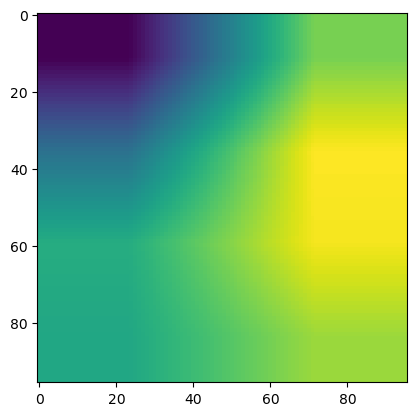

In [64]:
plt.imshow(result[0, 0, :, :, 1].cpu())

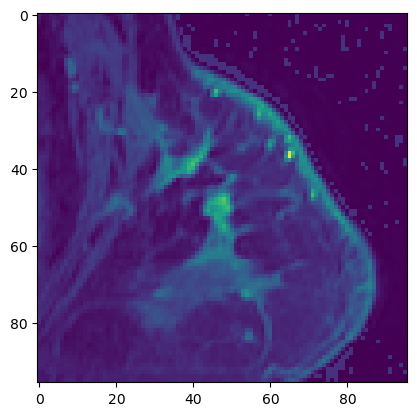

In [65]:
plt.imshow(val_dce[0, 0, :, :, 1].cpu())

In [15]:
# resnet 2d
from monai.networks.nets import seresnet50
from monai.visualize import GradCAM

x1 = torch.randn(1, 1, 96, 96, 32).to(device)  # batch, channel, x, y, z
x2 = torch.randn(1, 1, 64, 64, 16).to(device)

structured_data = torch.randn(1, 6).to(device)
rad = torch.rand(1, 9).to(device)

cam = GradCAM(nn_module=model, target_layers="model_dce.layer4")
result = cam(x=x1, class_idx=1)
print(result.shape)

torch.Size([1, 512])
torch.Size([1, 1, 96, 96, 32])


In [16]:
(result[..., 6] == result[..., 4]).all()

tensor(True, device='cuda:1')

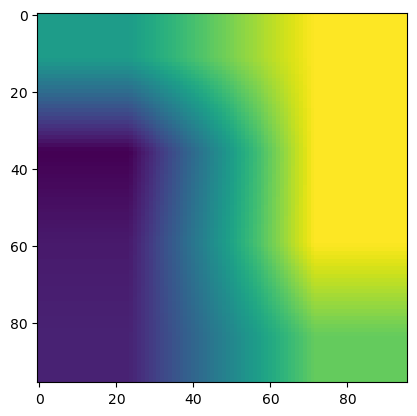

In [20]:
import matplotlib.pyplot as plt

plt.imshow(result[0, 0, :, :, 2].cpu())

In [29]:

class DoubleTower(nn.Module):
    def __init__(self,
                 pretrained_dce='',
                 pretrained_adc='',
                 device = torch.device("cuda"),
                 num_classes=2,
                 fc_hidden_size = 256
                ):
        super().__init__()
        self.pretrained_dce = pretrained_dce
        self.pretrained_adc = pretrained_adc
        self.fc_hidden_size = fc_hidden_size
        self.num_classes = num_classes
        self.device = device

        self.model_dce = monai.networks.nets.DenseNet(3, 1, 2).to(self.device)
        self.model_adc = monai.networks.nets.resnet34(spatial_dims=3, n_input_channels=1, num_classes=2, feed_forward=False).to(self.device)

        if  pretrained_dce != '':
            dce_dict = self.model_dce.state_dict()
            dce_pretrain = torch.load(self.pretrained_dce, map_location=self.device)
            dce_pretrain_dict = {k:v for k, v in dce_pretrain.items() if  k in  dce_dict.keys()}
            dce_dict.update(dce_pretrain_dict)
            self.model_dce.load_state_dict(dce_dict)


        if  pretrained_adc !='':
            adc_dict = self.model_adc.state_dict()
            adc_pretrain = torch.load(self.pretrained_adc, map_location=self.device)
            adc_pretrain_dict = {k:v for k, v in adc_pretrain.items() if  k in  adc_dict.keys()}
            adc_dict.update(adc_pretrain_dict)
            self.model_adc.load_state_dict(adc_dict)

        self.attn = nn.MultiheadAttention(512, num_heads=8, batch_first=True, device=self.device)

        # self.Linear1 = Linear(1024 + 6, self.num_classes, device=self.device)
        self.Linear1 = Linear(1024, self.fc_hidden_size, device=self.device)  # 1024 是 所有下采样特征图globalpool之后拼接的结果
        self.Linear2 = Linear(self.fc_hidden_size + 6 + 9, self.num_classes, device=self.device)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x1):  # x 是SegResNet的输入影像矩阵

        _, encode_output1 = self.model_dce(x1)   # output_1024
        #encode_output2 = self.model_dce(x2)

        #concatenated = encode_output1 * encode_output2

        #concatenated = concatenated.unsqueeze(1)
        #attn_output, _ = self.attn(concatenated, concatenated, concatenated)

        #attn_output = attn_output.squeeze(1)
        encode_output1 = torch.nn.functional.adaptive_avg_pool3d(encode_output1, (1,1, 1)).squeeze()

        fc1 = F.relu(self.Linear1(encode_output1))
        fc1 = self.dropout(fc1)

        fc2 = self.Linear2( torch.concat([fc1, rad, structured_data], dim=-1))
        return F.log_softmax(fc2, dim=-1)



my_model = DoubleTower()

x1 = torch.randn(8, 1, 96, 96, 32).cuda()  # batch, channel, x, y, z
x2 = torch.randn(8, 1, 94, 64, 16).cuda()
structured_data = torch.randn(8, 6).cuda()
rad = torch.randn(8, 9).cuda()
output = my_model(x1)
print('output: ', output.shape)


cam = GradCAM(nn_module=my_model, target_layers="model_dce.features.denseblock4.denselayer16.layers.relu2")
result = cam(x=x1, class_idx=1)
print(result.shape)

output:  torch.Size([8, 2])
torch.Size([8, 1, 96, 96, 32])


In [30]:
# for name, _ in my_model.named_modules(): 
#     print(name)

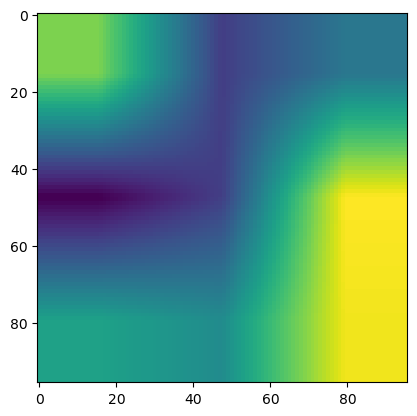

In [37]:
plt.imshow(result[0, 0, :, :, 1].cpu())